# Multilingual Sentence Indexing API

The purpose of this notebook is to build an API, that takes all kind of inputs and return the top N most probable FAQ_ids given any input text.

In previous notebooks, I have:
- build a CSV file: assign a FAQ_id to every questions. Questions with same id are semantically similar.
- build an Indexing model, stored in /codes/MultilingualSentencesIndexing.py
- Save Indexing model with data in /codes/multilingual_indexing_model.pkl

The Indexing model will:
- takes any input
- encodes the input into embeddings
- uses same similarity calculation method to get the similarity between input and all questions, by using their embeddings
- return the top_n closest questions with FAQ_id and some other informations

The task is simple, so I only define one endpoint for prediction:
- Validate input data, we only take 2 inputs: query (string) and top_n (int)
- Call Indexing model
- Return the top N most probable FAQ_ids

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#API" data-toc-modified-id="API-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>API</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span><ul class="toc-item"><li><span><a href="#Output-examples" data-toc-modified-id="Output-examples-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Output examples</a></span></li></ul></li><li><span><a href="#Next" data-toc-modified-id="Next-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Next</a></span></li></ul></div>

## Import Libraries

In [11]:
# API
from fastapi import FastAPI
from uvicorn import run
import os

# Data Validation
from pydantic import BaseModel

# Load model
import joblib

In [3]:
# Import package 
import sys  
sys.path.insert(0, '../codes/')

from MultilingualSentencesIndexing import *

## API

In [6]:
with open('../codes/multilingual_indexing_model.pkl', 'rb') as f:
    model = joblib.load(f)

# Reload preprocessor and encoder
model.preprocessor = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2"
)
model.encoder = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1"
)

class Data(BaseModel):
    query: str
    top_n: int

# Initializing FastAPI
api = FastAPI()

# Defining a test root path and message
@api.get('/')
def root():
    return {'message': 'Hello friends!'}


# Defining the indextion endpoint
# With data validation: make use of the Query data model 
# to ensure the request is with 2 features and all features match its data type
@api.post('/predict')
async def predict(data: Data):
    # Converting input data into Pandas DataFrame
    data = data.dict()
    # Getting the prediction from the Logistic Regression model
    pred = model.get_top_n_faqs(data['query'], data['top_n'])
    return pred

2022-11-25 09:38:20.521275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


## Testing

In [15]:
if __name__ == "__main__":
    config = uvicorn.Config(api, port=5555, host="0.0.0.0")
    server = uvicorn.Server(config)
    await server.serve()

INFO:     Started server process [2348]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:5555 (Press CTRL+C to quit)


INFO:     127.0.0.1:50338 - "POST /predict HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [2348]


### Output examples

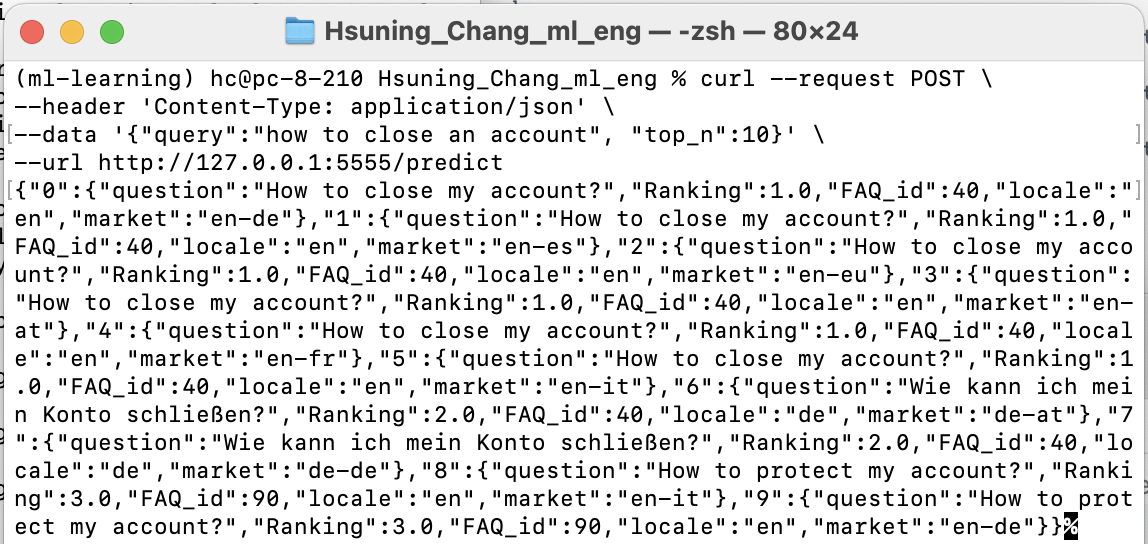

(ml-learning) hc@pc-8-210 Hsuning_Chang_ml_eng % curl --request POST \
--header 'Content-Type: application/json' \
--data '{"query":"deposit fee", "top_n":15}' \
--url http://0.0.0.0:5555/predict

{"0":{"question":"Deposit fee","Ranking":1.0,"FAQ_id":132,"locale":"en","market":"en-de"},"1":{"question":"Deposit fee","Ranking":1.0,"FAQ_id":132,"locale":"en","market":"en-it"},"2":{"question":"Deposit fee","Ranking":1.0,"FAQ_id":132,"locale":"en","market":"en-fr"},"3":{"question":"Deposit fee","Ranking":1.0,"FAQ_id":132,"locale":"en","market":"en-eu"},"4":{"question":"Frais de dépôt","Ranking":2.0,"FAQ_id":132,"locale":"fr","market":"fr-fr"},"5":{"question":"Documentos bancarios","Ranking":3.0,"FAQ_id":226,"locale":"es","market":"es-es"},"6":{"question":"Verwahrentgelt","Ranking":4.0,"FAQ_id":132,"locale":"de","market":"de-de"},"7":{"question":"Wie lange dauert eine Überweisung?","Ranking":5.0,"FAQ_id":273,"locale":"de","market":"de-at"},"8":{"question":"Wie lange dauert eine Überweisung?","Ranking":5.0,"FAQ_id":273,"locale":"de","market":"de-de"},"9":{"question":"Comment faire une réclamation ?","Ranking":6.0,"FAQ_id":191,"locale":"fr","market":"fr-fr"},"10":{"question":"Come fare un reclamo?","Ranking":7.0,"FAQ_id":191,"locale":"it","market":"it-it"},"11":{"question":"Kommunikationseinstellungen","Ranking":8.0,"FAQ_id":226,"locale":"de","market":"de-de"},"12":{"question":"Impostazioni per le comunicazioni di marketing","Ranking":9.0,"FAQ_id":231,"locale":"it","market":"it-it"},"13":{"question":"Latest updates on our customer service availability","Ranking":10.0,"FAQ_id":178,"locale":"en","market":"en-it"},"14":{"question":"Round-Up Savings","Ranking":11.0,"FAQ_id":56,"locale":"en","market":"en-it"}}%                                      

## Next
- The API will be stored in the folder /codes/api.py
- The next step is to package and ship the services using Docker